In [ ]:
from google.colab import files

comment_data_upload = files.upload()
stopword_data_upload = files.upload()
teencode_data_upload = files.upload()
validate_data_upload = files.upload()

Saving toxic_comment.csv to toxic_comment.csv


Saving teencode.txt to teencode.txt


Saving Vietnamese_stopwords_dash.txt to Vietnamese_stopwords_dash.txt


Saving validate_data.csv to validate_data.csv


# **1. Quan sát dữ liệu**

In [ ]:
import pandas as pd

# Tải dữ liệu
toxic_comment = pd.read_csv('toxic_comment.csv')
toxic_comment

,text,annotator1,label
0,xin mid gánh team với,0,0
1,bạn ơi,0,0
2,cho mid là win,0,0
3,câm à,1,1
4,cầm thanh tẩy,0,0
...,...,...,...
3125,thằng khùng tự dưng cắn bậy,1,1
3126,nó bị ngu ấy mà,1,1
3127,đéo biết ăn rồng hả,1,1
3128,lao vào mà đánh sợ chết hả thằng ngu,1,1


In [ ]:
# Kiểm tra có dòng nào đánh nhãn thiếu không
toxic_comment[toxic_comment['label'].isnull()].index.tolist()

[]

In [ ]:
# Xem các dòng, các cột
toxic_comment.shape

(3130, 3)

       text
label      
0      1947
1      1183


<Axes: xlabel='label'>

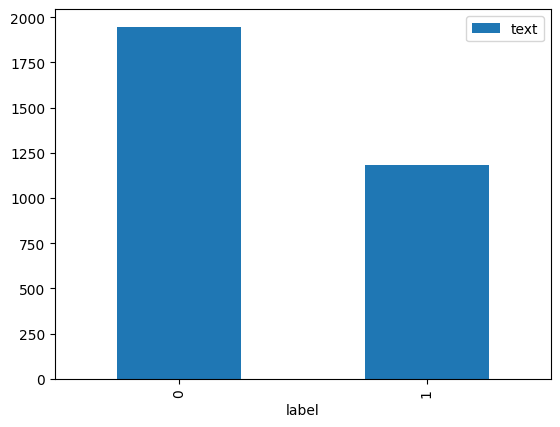

In [ ]:
# Tỉ lệ comment toxic và không toxic

label_rate = toxic_comment[['text','label']].groupby('label').count()
print(label_rate)
label_rate.plot(kind='bar',legend=True)

In [ ]:
from sklearn.metrics import cohen_kappa_score
annotator1 = toxic_comment['label']
annotator2 = toxic_comment['annotator1']
cohen_kappa_score(annotator1,annotator2)

0.9494685713363187

# **2. Tiền xử lý**

In [ ]:
!pip install underthesea

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Lấy danh sách teencode
import pandas as pd

teencode = pd.read_csv('teencode.txt', delimiter='\t', names=['abbr','full'])
teencode

,abbr,full
0,ctrai,con trai
1,khôg,không
2,bme,bỏ mẹ
3,cta,chúng ta
4,mih,mình
...,...,...
618,tui,tao
619,tôi,tao
620,z,vậy
621,hn,hôm nay


In [ ]:
# Lấy danh sách stopword
with open('Vietnamese_stopwords_dash.txt') as f:
  stopwords = []
  for line in f:
    stopwords.append(line.replace('\n',''))
stopwords

['.',
 ',',
 '!',
 '~',
 '@',
 '#',
 '$',
 '%',
 '"',
 '^',
 '&',
 '*',
 '(',
 ')',
 '/',
 '<',
 '>',
 '\\',
 '{',
 '}',
 '[',
 ']',
 '?',
 'a_lô',
 'a_ha',
 'ai',
 'ai_ai',
 'ai_nấy',
 'ai_đó',
 'alô',
 'amen',
 'anh',
 'anh_ấy',
 'ba',
 'ba_ba',
 'ba_bản',
 'ba_cùng',
 'ba_họ',
 'ba_ngày',
 'ba_ngôi',
 'ba_tăng',
 'bao_giờ',
 'bao_lâu',
 'bao_nhiêu',
 'bao_nả',
 'bay_biến',
 'biết',
 'biết_bao',
 'biết_bao_nhiêu',
 'biết_chắc',
 'biết_chừng_nào',
 'biết_mình',
 'biết_mấy',
 'biết_thế',
 'biết_trước',
 'biết_việc',
 'biết_đâu',
 'biết_đâu_chừng',
 'biết_đâu_đấy',
 'biết_được',
 'buổi',
 'buổi_làm',
 'buổi_mới',
 'buổi_ngày',
 'buổi_sớm',
 'bà',
 'bà_ấy',
 'bài',
 'bài_bác',
 'bài_bỏ',
 'bài_cái',
 'bác',
 'bán',
 'bán_cấp',
 'bán_dạ',
 'bán_thế',
 'bây_bẩy',
 'bây_chừ',
 'bây_giờ',
 'bây_nhiêu',
 'bèn',
 'béng',
 'bên',
 'bên_bị',
 'bên_có',
 'bên_cạnh',
 'bông',
 'bước',
 'bước_khỏi',
 'bước_tới',
 'bước_đi',
 'bạn',
 'bản',
 'bản_bộ',
 'bản_riêng',
 'bản_thân',
 'bản_ý',
 'bất_chợt'

In [ ]:
# Xóa khoảng trắng thừa trong câu
def remove_whitespace(text):
  trimmed_text = text.strip()
  tokens = trimmed_text.split()
  handled_list = []
  for token in tokens:
    if token != ' ':
      handled_list.append(token)
  return ' '.join(handled_list)

# Xóa từ cố tình viết dài
def remove_duplicate(text):
  tokens = text.split()
  token_list = []
  for token in tokens:
    cleaned_token = ''
    for index in range(0, len(token)):
      if index != len(token) - 1:
        if token[index] == token[index + 1]:
          continue
        else:
          cleaned_token += token[index]
      else:
        cleaned_token += token[index]
    token_list.append(cleaned_token)
  return ' '.join(token_list)

# Thay thế teencode
def replace_teencode(text, teencode):
  tokens = text.split()
  cleaned_text = []
  teencode_list = []
  for value in teencode['abbr']:
    teencode_list.append(value)
  for token in tokens:
    if token in teencode_list:
      new_token = teencode[teencode['abbr'] == token]['full'].unique()[0]
      cleaned_text.append(new_token)
    else:
      cleaned_text.append(token)
  return ' '.join(cleaned_text)

# Xóa stopword
def remove_stopword(comment, stopword):
  # Danh sách chứa comment đã được loại bỏ stopwords
  comments = []
  for word in comment.split(' '):
    # Chọn các từ không phải stopword
    if (word not in stopword):
      if ('_' in word) or (word.isalpha()):
        # Nối các từ trong tidy_word_list thành một comment hoàn chỉnh
        comments.append(word)
  return ' '.join(comments)

In [ ]:
# Tiền xử lý
from underthesea import word_tokenize, text_normalize

corpus = toxic_comment['text']

def preprocess_text(corpus):
  new_corpus = []
  for comment in corpus:
    # Chuyển comment về chữ thường
    lower_text = comment.lower()
    # Xóa khoảng trắng thừa
    removed_whitespace_text = remove_whitespace(lower_text)
    # Thay thế teencode lần 1
    replaced_text1 = replace_teencode(removed_whitespace_text, teencode)
    # Xóa từ cố tình viết trùng lặp nhiều kí tự
    removed_duplicate_text = remove_duplicate(replaced_text1)
    # Thay thế teencode lần 2
    replaced_text2 = replace_teencode(removed_duplicate_text, teencode)
    # Chuẩn hóa dấu câu
    nomalized_text = text_normalize(replaced_text2)
    # Tách từ
    tokenize_text = word_tokenize(nomalized_text, format='text')
    # Xóa stopwords
    clean_text = remove_stopword(tokenize_text, stopwords)
    # Thêm comment đã được làm sạch vào corpus mới
    new_corpus.append(clean_text)
  return new_corpus

toxic_comments = preprocess_text(corpus)
toxic_comments

['mid gánh team',
 '',
 'mid thắng',
 'câm',
 'cầm tẩy',
 'đầu_hàng',
 'vãi lồn sợ',
 'vãi lồn sợ',
 'đầu_hàng',
 '',
 'đứa',
 'đánh',
 'đánh ngu đầu_hàng',
 'thoát',
 'che tao',
 'tao chết',
 'chết',
 'buff xong thoát',
 'che',
 '',
 'chia sát_thương tao',
 '',
 'gank hoài đẩy',
 'lắm mõm',
 'đừng',
 'ngu',
 'tao ngu',
 'thằng ngu sủa lắm con_đĩ mẹ',
 'thằng ngu sủa lắm con_đĩ mẹ',
 'hy_sinh bố gánh',
 'bố',
 'mai mẹ_mày chết',
 'rủa đi vận',
 'ping',
 'đứng cặc',
 'đứng cặc',
 'thằng ngu',
 'đầu_hàng',
 'rồng đi',
 'đấy đầu_hàng đi',
 'bảo che đi',
 'che sóng_âm đấy',
 'đập tao chết',
 'mày chết đi',
 'hi_sinh',
 'tao',
 'admin đường',
 '',
 'đi',
 'đánh mid đường',
 'đi',
 'đầu_hàng đấy',
 'rừng',
 'trừng_phạt đi',
 'tao def đường',
 'cút',
 'mày ashe',
 'admin ngu',
 'vợ_chồng',
 'vãi cặc',
 'sát_thương cặc',
 'sát_thương cặc',
 'ẳng',
 'lo xong thân đi',
 'tý đầu dám cãi bố',
 'admin ngu lồn',
 'admin ngu lồn',
 'mày bắn đấy',
 'chó',
 'admin cặc',
 'mẹ chết',
 'sợ',
 'giết',
 'đị

# **3. Tạo feature vector**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Tính tf-idf : min-df - xóa những từ xuất hiện ít hơn 1, max-df - xóa những từ có tần xuất xuất hiện trên 50%
vectorizer = TfidfVectorizer()
vectorizer.fit(toxic_comments)
X_transform = vectorizer.transform(toxic_comments)

# Tách dữ liệu theo tỉ lệ 8 : 2
X_train, X_test, y_train, y_test = train_test_split(X_transform, toxic_comment['label'], test_size=0.2, random_state=42)
pd.DataFrame(X_train.todense(), columns = vectorizer.get_feature_names_out())

,_admin,_rank,acount,admin,al,alo,an_toàn,anh_em,anh_hùng,anti,...,ảnh,ảo,ấn,ấn_tượng,ẩu,ẳng,ỉa,ồn,ổn,ừm
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2499,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2501,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2502,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# **4. Huấn luyện mô hình**

**a. LinearRegression**

In [ ]:
# Huấn luyện mô hình LogisticRegression
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train,y_train)

LogisticRegression()

**b. SVM**

In [ ]:
# Huấn luyện mô hình SVM
from sklearn import svm

svm_classifier = svm.SVC(kernel='linear')

svm_classifier.fit(X_train, y_train)

SVC(kernel='linear')

# **5. Dự đoán**

**a. LogisticRegression**

In [ ]:
y_predict_lrg = model.predict(X_test)
y_predict_lrg

array([0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,

**b. SVM**

In [ ]:
y_predict_svm = svm_classifier.predict(X_test)
y_predict_svm

array([0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,

#**6. Đánh giá mô hình**

**a. LogisticRegression**

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_test, y_predict_lrg) * 100

88.20754716981133

**b. SVM**

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_test, y_predict_svm) * 100

94.73684210526315

**c. Kiểm thử trên tập validation**

In [ ]:
# Đọc dữ liệu
import pandas as pd

validation_data = pd.read_csv('validate_data.csv')
validation_data

,text,label
0,ra đây đê gấu,0
1,thane dốt vãi,1
2,thằng mid phế vãi,1
3,m sẽ phải trả giá,0
4,vãi lồn,1
5,afkkkkkk,0
6,thằng mid biết chơi k thế,0
7,afk cung chịu,0
8,vãi l,1
9,thằng mid óc chó,1


In [ ]:
# Lấy X và y
X_val_raw = validation_data['text']
X_val = vectorizer.transform(preprocess_text(X_val_raw))
y_val = validation_data['label']

In [ ]:
# Kiểm thử và đánh giá với LinearRegression
from sklearn.metrics import f1_score
y_pred_lr = model.predict(X_val)
f1_score(y_val,y_pred_lr) * 100

76.92307692307693

In [ ]:
# Kiểm thử với SVM
from sklearn.metrics import f1_score
y_pred_svm = svm_classifier.predict(X_val)
f1_score(y_val,y_pred_svm) * 100

76.92307692307693

**d. Test some data**

In [ ]:
def predict_comment(comments,vectorizer, model_x):
  result_list = []
  for comment in comments:
    cleaned_comment = preprocess_text(comment)
    comment_transform = vectorizer.transform(cleaned_comment)
    y_predict = model_x.predict(comment_transform)
    result_list.append(f'{comment} : {y_predict}')
  return result_list

comments = [['m bị ngu à. Không chịu ăn rồng đi'],['team toàn óc'],['súc vật'],['thằng mid đánh chán thật'],['vl thật']]
results = predict_comment(comments, vectorizer, model)
for item in results:
  print(item)

['m bị ngu à. Không chịu ăn rồng đi'] : [1]
['team toàn óc'] : [0]
['súc vật'] : [1]
['thằng mid đánh chán thật'] : [0]
['vl thật'] : [1]


# **7. Cải thiện mô hình**

**a. LogisticRegression**

In [ ]:
# sử dụng chiến lược tinh chỉnh tham số GridSearchCV để tìm ra bộ tham số tốt nhất cho mô hình Logistic Regression
# Tạo GridSearch
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
import numpy as np

grid=[
    {"C": np.logspace(-3,3,10),
     "penalty":["l1","l2","elasticnet"],
     "solver": ["lbfgs", "liblinear", "newton-cholesky"],
     "max_iter": [100,250,500, 750, 1000]
     }]
logreg = LogisticRegression(random_state=40)
logreg_cv=GridSearchCV(logreg,grid,cv=5)
logreg_cv.fit(X_train,y_train)
logreg_cv.best_estimator_

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

LogisticRegression(C=10.0, penalty='l1', random_state=40, solver='liblinear')

In [1]:
# Đánh giá mô hình
from sklearn.metrics import f1_score
y_predict_lrg = logreg_cv.predict(X_test)
f1_score(y_test, y_predict_lrg) * 100

NameError: name 'logreg_cv' is not defined

**b. SVM**

In [ ]:
# Huấn luyện mô hình
from sklearn.model_selection import GridSearchCV
from sklearn import svm

grid = [
    {
        'kernel': ["linear", "rbf", "sigmoid"],
        'C': np.logspace(-3,3,10)
    }]

svm_clf = svm.SVC(random_state=40)
best_svm_clf = GridSearchCV(svm_clf, grid, cv=5)
best_svm_clf.fit(X_train, y_train)
best_svm_clf.best_estimator_

SVC(C=2.154434690031882, kernel='linear', random_state=40)

In [ ]:
# Đánh giá mô hình
from sklearn.metrics import f1_score
y_predict_svm = logreg_cv.predict(X_test)
f1_score(y_test, y_predict_svm) * 100

95.23809523809523

**c. Kiểm thử trên tập validation**

In [ ]:
# Kiểm thử và đánh giá với LinearRegression
from sklearn.metrics import f1_score
y_pred_lr = logreg_cv.predict(X_val)
f1_score(y_val,y_pred_lr)

0.8148148148148148

In [ ]:
# Kiểm thử với SVM
from sklearn.metrics import f1_score
y_pred_svm = best_svm_clf.predict(X_val)
f1_score(y_val,y_pred_svm)

0.8148148148148148

**d. Test some data**

In [ ]:
def predict_comment(comments,vectorizer, model_x):
  result_list = []
  for comment in comments:
    cleaned_comment = preprocess_text(comment)
    comment_transform = vectorizer.transform(cleaned_comment)
    y_predict = model_x.predict(comment_transform)
    result_list.append(f'{comment} : {y_predict}')
  return result_list

comments = [['m bị ngu à. Không chịu ăn rồng đi'],['team toàn óc'],['súc vật'],['thằng mid đánh chán thật'],['vl thật'],]
results = predict_comment(comments, vectorizer, best_svm_clf)
for item in results:
  print(item)

['m bị ngu à. Không chịu ăn rồng đi'] : [1]
['team toàn óc'] : [1]
['súc vật'] : [1]
['thằng mid đánh chán thật'] : [0]
['vl thật'] : [1]
